In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
style = '<style>svg{width:50% !importamt;height:50% !important;}<style>'
HTML(style)

In [3]:
pd.set_option('display.max_columns', None)
titanic_train = pd.read_csv('train.csv')
titanic_test = pd.read_csv('test.csv')

In [4]:
df = pd.concat([titanic_train, titanic_test], axis=0)

In [5]:
temp_df = df[['Ticket', 'Fare']].value_counts().reset_index()
temp_df['Price'] = temp_df['Fare']/temp_df[0]
temp_df.rename(columns={0:'Ticket_Count'},inplace=True)
temp_df

Ticket     Fare  Ticket_Count     Price
0    CA. 2343  69.5500            11  6.322727
1        1601  56.4958             8  7.061975
2     CA 2144  46.9000             8  5.862500
3     3101295  39.6875             7  5.669643
4      347077  31.3875             7  4.483929
..        ...      ...           ...       ...
924    342826   8.0500             1  8.050000
925    343095   8.0500             1  8.050000
926    343120   7.6500             1  7.650000
927    343271   7.0000             1  7.000000
928    349223   7.8958             1  7.895800

[929 rows x 4 columns]

In [6]:
df = pd.merge(df, temp_df, how='left', on=['Ticket', 'Fare'])

In [7]:
def cabin_count(x):
    if str(x) == 'nan':
        return 0
    else: return len(str(x).split(" "))
df['Cabin_Count'] =df['Cabin'].apply(cabin_count)
df['Price'].replace(to_replace=0,value=np.nan,inplace=True)
ddf =df.groupby(['Sex','Ticket_Count','Cabin_Count'])['Price'].median().reset_index()

In [8]:
df1 =df.copy()
df1 = pd.merge(df1, ddf, how='left', on=['Sex','Ticket_Count','Cabin_Count'])

In [9]:
df['Price'] = df['Price'].fillna(df1['Price_y'])
df['Price'].fillna(df['Price'].median(), inplace=True)


In [10]:
def show_val(x):
    sns.displot(data=df, x = x, hue ='Survived', multiple="dodge", color='blue')#, n_boot=1, kind='bar'
    plt.title(f'{x} vs Survival ')
    plt.show()
    print(df.groupby(x)['Survived'].mean().reset_index().sort_values(by=x))

In [11]:
df['Price_Category'] = pd.cut(df['Price'], bins=[0,7.90,14.45,31.28,140], labels=['Low','Mid', 'High_Mid','High'])

In [12]:
df['family'] = df['SibSp']+df['Parch']
df['Alone'] = 1
df['Alone'] = df['family'] == 0
df['Alone'] = df['Alone'].astype('int')

In [13]:
age_gr = pd.pivot_table(df, index=['Sex', 'Pclass'], values=['Age'], aggfunc = np.median)
df2 = df.copy()
df2 = pd.merge(df, age_gr, how='left', on=['Sex', 'Pclass'])
df['Age'] = df['Age'].fillna(df2['Age_y'])

In [14]:
df['Age_Range'] = pd.cut(df['Age'], bins=range(0, 90, 10), labels=['0,10','10,20', '20,30', '30,40','40,50', '50,60', '60,70', '70,80'])

In [15]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Cabin'] = df['Cabin'].fillna('Na')

In [16]:
df_train = df[df['PassengerId']<892].set_index('PassengerId')
df_test = df[df['PassengerId']>=892].set_index('PassengerId')

In [17]:
X_train = df_train.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'Ticket_Count', 'Fare'], axis=1)
Y_train = df_train.Survived
X_train = pd.get_dummies(X_train, drop_first=True)
X_to_be_predict = df_test.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'Ticket_Count', 'Fare'], axis=1)
X_to_be_predict = pd.get_dummies(X_to_be_predict, drop_first=True)

In [18]:
X_train = X_train.drop(['Age', 'SibSp', 'Parch', 'Price', 'family'], axis=1)
X_to_be_predict = X_to_be_predict.drop(['Age', 'SibSp', 'Parch', 'Price', 'family'], axis=1)


In [19]:
X_to_be_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Pclass                   418 non-null    int64
 1   Cabin_Count              418 non-null    int64
 2   Alone                    418 non-null    int32
 3   Sex_male                 418 non-null    uint8
 4   Embarked_Q               418 non-null    uint8
 5   Embarked_S               418 non-null    uint8
 6   Price_Category_Mid       418 non-null    uint8
 7   Price_Category_High_Mid  418 non-null    uint8
 8   Price_Category_High      418 non-null    uint8
 9   Age_Range_10,20          418 non-null    uint8
 10  Age_Range_20,30          418 non-null    uint8
 11  Age_Range_30,40          418 non-null    uint8
 12  Age_Range_40,50          418 non-null    uint8
 13  Age_Range_50,60          418 non-null    uint8
 14  Age_Range_60,70          418 non-null    uint8
 15  Age

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2)

In [21]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
X_pred_np = X_to_be_predict.to_numpy()

In [22]:
y_train_cat = keras.utils.to_categorical(Y_train, 2)
y_test_cat = keras.utils.to_categorical(Y_test, 2)

In [104]:
model = keras.Sequential([
    Input(shape=(16,)),
    Dense(120, activation='relu'),
    Dense(60, activation='relu'),
    #Dropout(0.2),
    #BatchNormalization(),
    Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 120)               2040      
                                                                 
 dense_44 (Dense)            (None, 60)                7260      
                                                                 
 dense_45 (Dense)            (None, 2)                 122       
                                                                 
Total params: 9,422
Trainable params: 9,422
Non-trainable params: 0
_________________________________________________________________


In [105]:
model.compile(optimizer=keras.optimizers.Adam(0.0001),#'adam',#!
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/10
38/38 [==============================] - 0s 4ms/step - loss: 0.7286 - accuracy: 0.4112 - val_loss: 0.6670 - val_accuracy: 0.6944
Epoch 2/10
38/38 [==============================] - 0s 1ms/step - loss: 0.6624 - accuracy: 0.6331 - val_loss: 0.6150 - val_accuracy: 0.6944
Epoch 3/10
38/38 [==============================] - 0s 975us/step - loss: 0.6307 - accuracy: 0.6509 - val_loss: 0.5854 - val_accuracy: 0.7222
Epoch 4/10
38/38 [==============================] - 0s 1ms/step - loss: 0.6117 - accuracy: 0.6553 - val_loss: 0.5689 - val_accuracy: 0.7222
Epoch 5/10
38/38 [==============================] - 0s 1ms/step - loss: 0.5960 - accuracy: 0.6701 - val_loss: 0.5577 - val_accuracy: 0.7222
Epoch 6/10
38/38 [==============================] - 0s 1ms/step - loss: 0.5823 - accuracy: 0.6879 - val_loss: 0.5503 - val_accuracy: 0.7500
Epoch 7/10
38/38 [==============================] - 0s 932us/step - loss: 0.5694 - accuracy: 0.7071 - val_loss: 0.5405 - val_accuracy: 0.7778
Epoch 8/10
38/38

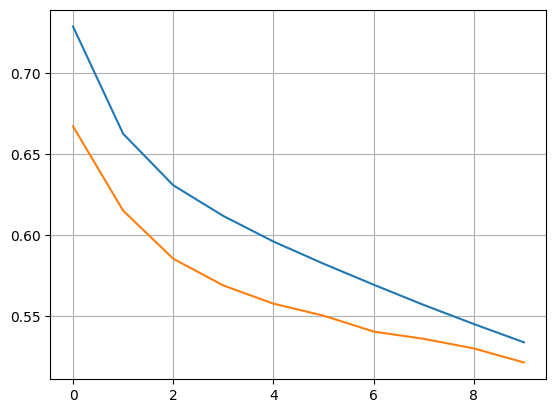

In [106]:
history = model.fit(X_train_np, y_train_cat, batch_size=18, epochs=10, validation_split=0.05)
model.evaluate(X_test_np, y_test_cat)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.show()

In [32]:
X_test_np[1]

array([2, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [103]:
resx = model.predict(X_pred_np)
res = np.argmax(resx, axis=1)
y_pred = pd.DataFrame({'Survived': res})
y_pred.index = X_to_be_predict.index
print(y_pred.head())
y_pred.to_csv('Submission.csv')

             Survived
PassengerId          
892                 0
893                 0
894                 0
895                 0
896                 0
